In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet
from sklearn.model_selection import train_test_split

2023-03-24 21:40:48.560608: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
import tensorflow as tf

In [4]:
gpu_avail = tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-03-24 21:40:55.463642: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 21:40:55.470230: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-24 21:40:55.600001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-24 21:40:55.600041: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-24 21:40:55.650837: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] 

In [5]:
gpu_avail

True

In [6]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [7]:
images = np.load(images_file)
labels = np.load(labels_file)

In [8]:
images.ndim, labels.ndim

(3, 3)

In [9]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [10]:
p = np.random.permutation(len(images))

In [11]:
images = images[p]
labels = labels[p]

In [12]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [13]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [14]:
images.shape

(766, 512, 512, 1)

In [15]:
labels.shape

(766, 512, 512, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


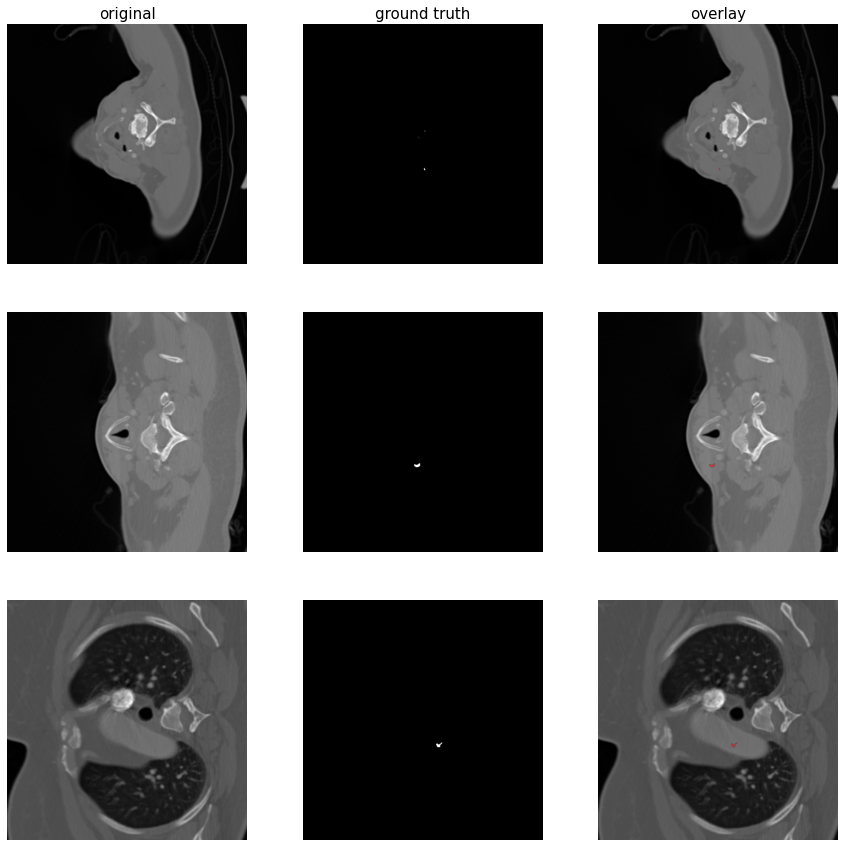

In [16]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [17]:
#X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=0)

In [19]:
import json

In [21]:
with open("images_data_v3.json", "r") as fp:
    label_data = json.load(fp)

In [22]:
label_data['82']

596

In [23]:
X_train = images[0:label_data['82']]
y_train = labels[0:label_data['82']]
X_val = images[label_data['82']:]
y_val = labels[label_data['82']:]

In [24]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 2, 2, 2], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-03-24 21:42:21.298559: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-24 21:42:21.306383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-03-24 21:42:21.310750: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-24 21:42:21.318981: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-03-24 21:42:21.319014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-03-24 21:42:21.319018: I tensorflow/core/common_runtime/gp

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [25]:
model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 16384, 16)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 16384, 64)    1049664     patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 16384, 64)    83460       patch_embedding[0][0]            
____________________________________________________________________________________

In [26]:
from tensorflow.keras import optimizers
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses

In [27]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr = 0.001),
              metrics=[iou, iou_thresholded])

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [28]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=16,
                    epochs=100,
                    validation_data=(X_val, y_val))

2023-03-24 21:42:32.533151: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-24 21:42:32.553176: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/100


2023-03-24 21:42:57.317615: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-24 21:42:58.781510: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-03-24 21:42:58.781849: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-24 21:42:58.929763: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-03-24 21:43:00.168897: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-03-24 21:43:01.819470: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-03-24 21:43:01.819496: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-03-24 21:43:01.82027

38/38 [==============================] - 66s 939ms/step - loss: 0.0705 - iou: 5.0616e-04 - iou_thresholded: 5.1241e-04 - val_loss: 0.0071 - val_iou: 6.6822e-04 - val_iou_thresholded: 7.2141e-04
Epoch 2/100
38/38 [==============================] - 30s 797ms/step - loss: 0.0098 - iou: 0.0016 - iou_thresholded: 0.0020 - val_loss: 0.0061 - val_iou: 0.0073 - val_iou_thresholded: 0.0098
Epoch 3/100
38/38 [==============================] - 30s 800ms/step - loss: 0.0060 - iou: 0.0085 - iou_thresholded: 0.0126 - val_loss: 0.0042 - val_iou: 0.0126 - val_iou_thresholded: 0.0184
Epoch 4/100
38/38 [==============================] - 30s 801ms/step - loss: 0.0039 - iou: 0.0204 - iou_thresholded: 0.0264 - val_loss: 0.0029 - val_iou: 0.0105 - val_iou_thresholded: 0.0029
Epoch 5/100
38/38 [==============================] - 30s 799ms/step - loss: 0.0032 - iou: 0.0248 - iou_thresholded: 0.0314 - val_loss: 0.0024 - val_iou: 0.0152 - val_iou_thresholded: 0.0093
Epoch 6/100
38/38 [===========================

38/38 [==============================] - 30s 797ms/step - loss: 0.0661 - iou: 0.0031 - iou_thresholded: 0.0033 - val_loss: 0.0592 - val_iou: 0.0023 - val_iou_thresholded: 0.0025
Epoch 44/100
38/38 [==============================] - 30s 802ms/step - loss: 0.0598 - iou: 0.0035 - iou_thresholded: 0.0034 - val_loss: 0.0499 - val_iou: 0.0025 - val_iou_thresholded: 0.0028
Epoch 45/100
38/38 [==============================] - 30s 797ms/step - loss: 0.0531 - iou: 0.0038 - iou_thresholded: 0.0038 - val_loss: 0.0489 - val_iou: 0.0022 - val_iou_thresholded: 0.0022
Epoch 46/100
38/38 [==============================] - 30s 802ms/step - loss: 0.0483 - iou: 0.0041 - iou_thresholded: 0.0041 - val_loss: 0.0456 - val_iou: 0.0026 - val_iou_thresholded: 0.0027
Epoch 47/100
38/38 [==============================] - 30s 798ms/step - loss: 0.0471 - iou: 0.0039 - iou_thresholded: 0.0038 - val_loss: 0.0457 - val_iou: 0.0028 - val_iou_thresholded: 0.0029
Epoch 48/100
38/38 [==============================] - 30s 

Epoch 86/100
38/38 [==============================] - 30s 799ms/step - loss: 0.0098 - iou: 0.0072 - iou_thresholded: 0.0063 - val_loss: 0.0103 - val_iou: 0.0054 - val_iou_thresholded: 0.0050
Epoch 87/100
38/38 [==============================] - 31s 805ms/step - loss: 0.0093 - iou: 0.0081 - iou_thresholded: 0.0066 - val_loss: 0.0091 - val_iou: 0.0053 - val_iou_thresholded: 0.0046
Epoch 88/100
38/38 [==============================] - 30s 796ms/step - loss: 0.0089 - iou: 0.0089 - iou_thresholded: 0.0074 - val_loss: 0.0092 - val_iou: 0.0062 - val_iou_thresholded: 0.0058
Epoch 89/100
38/38 [==============================] - 30s 800ms/step - loss: 0.0086 - iou: 0.0088 - iou_thresholded: 0.0077 - val_loss: 0.0096 - val_iou: 0.0064 - val_iou_thresholded: 0.0059
Epoch 90/100
38/38 [==============================] - 30s 801ms/step - loss: 0.0082 - iou: 0.0099 - iou_thresholded: 0.0092 - val_loss: 0.0095 - val_iou: 0.0065 - val_iou_thresholded: 0.0059
Epoch 91/100
38/38 [=========================

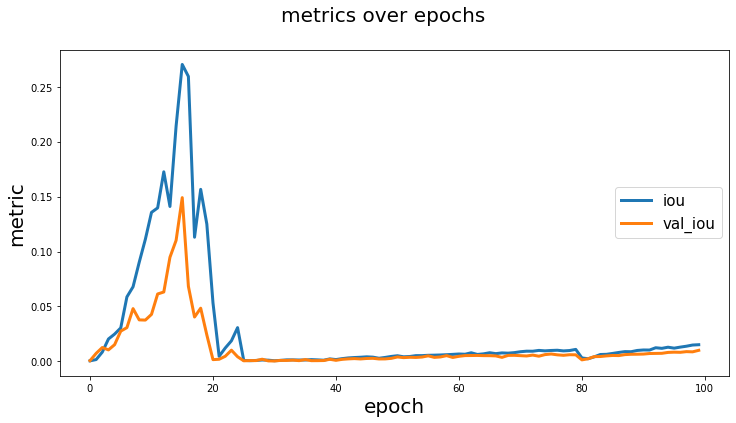

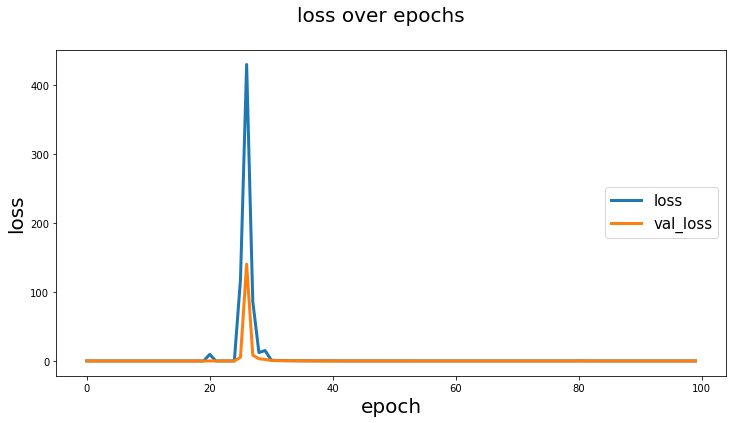

In [29]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [30]:
y_pred = model.predict(X_val)

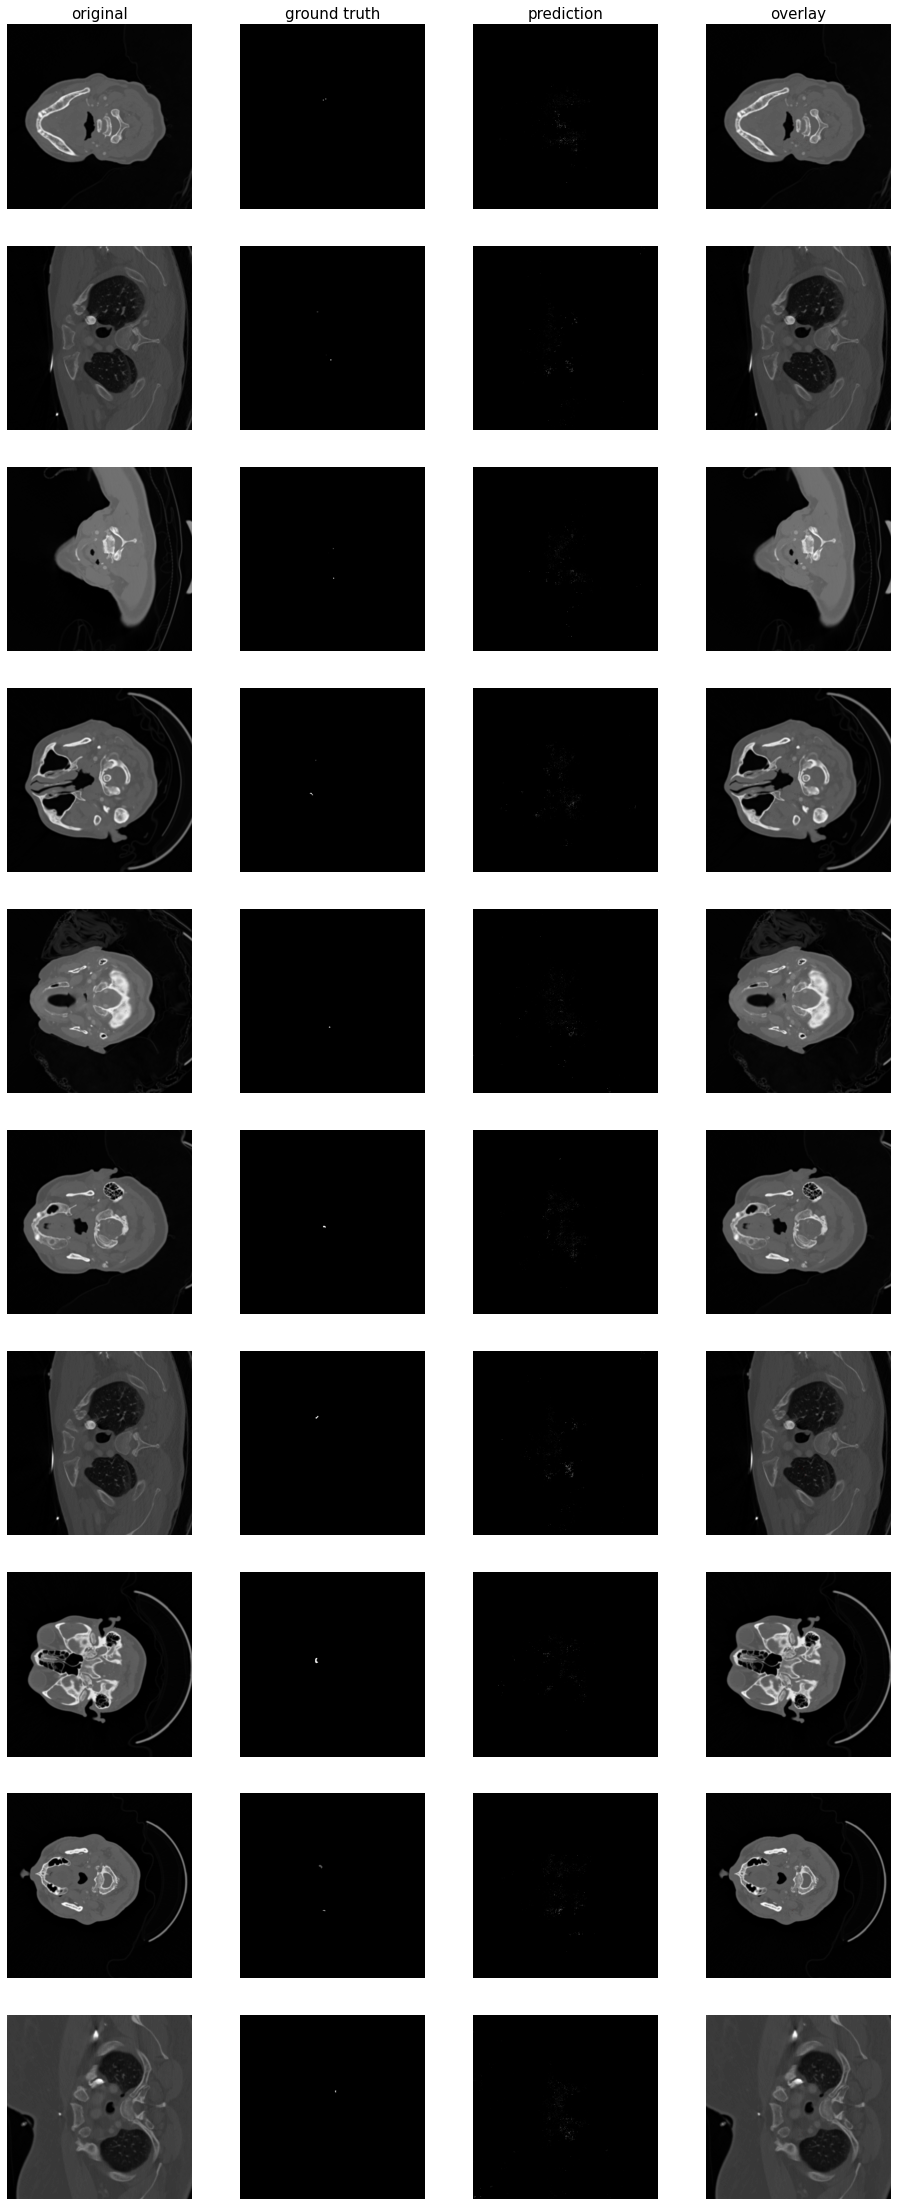

In [31]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [32]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

6/6 [==============================] - 2s 389ms/step - loss: 0.0080 - iou: 0.0099 - iou_thresholded: 0.0102
